In [68]:
import yfinance as yf
import matplotlib.pyplot as plt


# Download historical data for DJIA
djia = yf.Ticker('^DJI')
historical_data = djia.history(period="max")

# Save to CSV
historical_data.to_csv('DJIA_historical_data.csv')


In [79]:
!pip install ta

In [69]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score

# Fetch historical data for DJIA
djia = yf.Ticker('^DJI')
historical_data = djia.history(period="5y")  # Fetching data for the last 5 years

# Calculate additional features
historical_data['10_day_MA'] = historical_data['Close'].rolling(window=10).mean()
historical_data['50_day_MA'] = historical_data['Close'].rolling(window=50).mean()

# Drop rows with NaN values
historical_data = historical_data.dropna()

# Prepare the data
features = historical_data[['Close',  'Volume', '10_day_MA', '50_day_MA']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 60

# Create sequences for training
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shapes to ensure they match
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Reshape X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Create LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1)))))[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - features[train_size+sequence_length:, 0]) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(features[train_size+sequence_length:, 0], predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = r2_score(features[train_size+sequence_length:, 0], predictions)
print(f"R-squared: {r2}")

# Predict the next day's closing price
next_day_prediction = model.predict(np.array([test_data[-sequence_length:]]).reshape(1, sequence_length, X_test.shape[2]))
next_day_prediction = scaler.inverse_transform(np.hstack((next_day_prediction, np.zeros((next_day_prediction.shape[0], scaled_data.shape[1]-1)))))[:, 0]
print(f"The predicted closing price for the next day is: {next_day_prediction[0]:.2f}")


X_train shape: (908, 60, 4), y_train shape: (908,)
X_test shape: (182, 60, 4), y_test shape: (182,)
Epoch 1/25
29/29 [==============================] - 12s 103ms/step - loss: 0.0478
Epoch 2/25
29/29 [==============================] - 3s 91ms/step - loss: 0.0083
Epoch 3/25
29/29 [==============================] - 3s 90ms/step - loss: 0.0067
Epoch 4/25
29/29 [==============================] - 3s 90ms/step - loss: 0.0065
Epoch 5/25
29/29 [==============================] - 5s 156ms/step - loss: 0.0060
Epoch 6/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0056
Epoch 7/25
29/29 [==============================] - 3s 94ms/step - loss: 0.0056
Epoch 8/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0051
Epoch 9/25
29/29 [==============================] - 4s 129ms/step - loss: 0.0058
Epoch 10/25
29/29 [==============================] - 4s 124ms/step - loss: 0.0043
Epoch 11/25
29/29 [==============================] - 3s 100ms/step - loss: 0.0051
Epoch 12/25


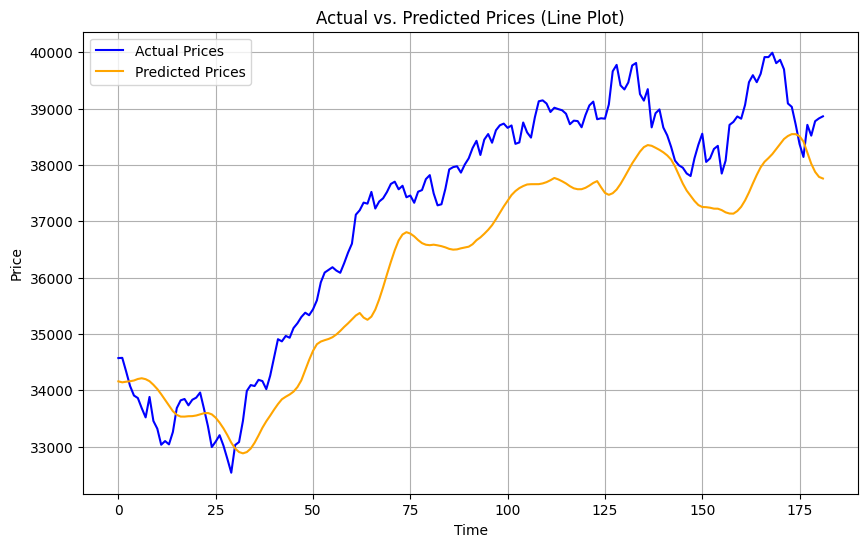

In [72]:
import matplotlib.pyplot as plt

# Assuming actual_prices and predicted_prices have the same length
actual_prices = historical_data.iloc[train_size+sequence_length:, 0].values
predicted_prices = predictions[:len(actual_prices)]  # Ensure predicted_prices has the same length as actual_prices

# Plot line plot for actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices (Line Plot)')
plt.legend()
plt.grid(True)
plt.show()



In [73]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score

# Fetch historical data for DJIA
djia = yf.Ticker('^DJI')
historical_data = djia.history(period="5y")  # Fetching data for the last 5 years

# Calculate additional features
historical_data['10_day_MA'] = historical_data['Close'].rolling(window=10).mean()
historical_data['50_day_MA'] = historical_data['Close'].rolling(window=50).mean()

# Momentum
historical_data['Momentum'] = historical_data['Close'] - historical_data['Close'].shift(4)

# RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

historical_data['RSI'] = compute_rsi(historical_data['Close'])

# MACD
historical_data['12_day_EMA'] = historical_data['Close'].ewm(span=12, adjust=False).mean()
historical_data['26_day_EMA'] = historical_data['Close'].ewm(span=26, adjust=False).mean()
historical_data['MACD'] = historical_data['12_day_EMA'] - historical_data['26_day_EMA']
historical_data['Signal_Line'] = historical_data['MACD'].ewm(span=9, adjust=False).mean()

# Drop rows with NaN values
historical_data = historical_data.dropna()

# Prepare the data
features = historical_data[['Close',  'Volume', '10_day_MA', '50_day_MA', 'Momentum', 'RSI', 'MACD', 'Signal_Line']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 60

# Create sequences for training
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Create LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1)))))[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - features[train_size+sequence_length:, 0]) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(features[train_size+sequence_length:, 0], predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = r2_score(features[train_size+sequence_length:, 0], predictions)
print(f"R-squared: {r2}")

# Predict the next day's closing price
next_day_prediction = model.predict(np.array([test_data[-sequence_length:]]).reshape(1, sequence_length, X_test.shape[2]))
next_day_prediction = scaler.inverse_transform(np.hstack((next_day_prediction, np.zeros((next_day_prediction.shape[0], scaled_data.shape[1]-1)))))[:, 0]
print(f"The predicted closing price for the next day is: {next_day_prediction[0]:.2f}")


Epoch 1/25
29/29 [==============================] - 9s 80ms/step - loss: 0.0410
Epoch 2/25
29/29 [==============================] - 2s 81ms/step - loss: 0.0082
Epoch 3/25
29/29 [==============================] - 2s 80ms/step - loss: 0.0068
Epoch 4/25
29/29 [==============================] - 2s 81ms/step - loss: 0.0068
Epoch 5/25
29/29 [==============================] - 4s 131ms/step - loss: 0.0063
Epoch 6/25
29/29 [==============================] - 3s 85ms/step - loss: 0.0054
Epoch 7/25
29/29 [==============================] - 2s 81ms/step - loss: 0.0051
Epoch 8/25
29/29 [==============================] - 2s 80ms/step - loss: 0.0045
Epoch 9/25
29/29 [==============================] - 2s 80ms/step - loss: 0.0047
Epoch 10/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0049
Epoch 11/25
29/29 [==============================] - 3s 105ms/step - loss: 0.0043
Epoch 12/25
29/29 [==============================] - 2s 81ms/step - loss: 0.0050
Epoch 13/25
29/29 [===============

In [74]:
#features calculation\
import yfinance as yf

# Fetch historical data for DJIA (Dow Jones Industrial Average)
djia = yf.Ticker('^DJI')
historical_data = djia.history(period="5y")  # Fetching data for the last 5 years

# Print the first few rows of historical data
print(historical_data.head())
# Calculate the closing price
closing_price = historical_data['Close']

# Calculate the volume
volume = historical_data['Volume']


                                   Open          High           Low  \
Date                                                                  
2019-06-10 00:00:00-04:00  26090.220703  26210.609375  26054.310547   
2019-06-11 00:00:00-04:00  26180.589844  26248.669922  25998.869141   
2019-06-12 00:00:00-04:00  26040.300781  26082.099609  25958.660156   
2019-06-13 00:00:00-04:00  26036.939453  26146.910156  25995.710938   
2019-06-14 00:00:00-04:00  26076.359375  26162.279297  25988.089844   

                                  Close     Volume  Dividends  Stock Splits  
Date                                                                         
2019-06-10 00:00:00-04:00  26062.679688  249280000        0.0           0.0  
2019-06-11 00:00:00-04:00  26048.509766  253490000        0.0           0.0  
2019-06-12 00:00:00-04:00  26004.830078  223690000        0.0           0.0  
2019-06-13 00:00:00-04:00  26106.769531  213400000        0.0           0.0  
2019-06-14 00:00:00-04:00  26089.6

In [75]:
#adding RSI relative strength index
import yfinance as yf
import numpy as np
import pandas as pd

# Fetch historical data for DJIA
djia = yf.Ticker('^DJI')
historical_data = djia.history(period="5y")  # Fetching data for the last 5 years

# Calculate RSI function
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI and add it to historical data
historical_data['RSI'] = calculate_rsi(historical_data['Close'])

# Print the first few rows of historical data with RSI
print(historical_data.head())


                                   Open          High           Low  \
Date                                                                  
2019-06-10 00:00:00-04:00  26090.220703  26210.609375  26054.310547   
2019-06-11 00:00:00-04:00  26180.589844  26248.669922  25998.869141   
2019-06-12 00:00:00-04:00  26040.300781  26082.099609  25958.660156   
2019-06-13 00:00:00-04:00  26036.939453  26146.910156  25995.710938   
2019-06-14 00:00:00-04:00  26076.359375  26162.279297  25988.089844   

                                  Close     Volume  Dividends  Stock Splits  \
Date                                                                          
2019-06-10 00:00:00-04:00  26062.679688  249280000        0.0           0.0   
2019-06-11 00:00:00-04:00  26048.509766  253490000        0.0           0.0   
2019-06-12 00:00:00-04:00  26004.830078  223690000        0.0           0.0   
2019-06-13 00:00:00-04:00  26106.769531  213400000        0.0           0.0   
2019-06-14 00:00:00-04:00  2

In [76]:
#MACD
import pandas as pd

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate the short-term exponential moving average (EMA)
    short_ema = data.ewm(span=short_window, adjust=False).mean()

    # Calculate the long-term exponential moving average (EMA)
    long_ema = data.ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    macd_line = short_ema - long_ema

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

# Example usage
# Load your stock data into a DataFrame, with 'Date' as index and 'Close' as a column
# For example, assuming your DataFrame is named 'stock_data'
stock_data = pd.read_csv('/content/DJIA_historical_data.csv', index_col='Date')

# Calculate MACD
macd_line, signal_line, macd_histogram = calculate_macd(stock_data['Close'])

# Print or use MACD values
print(macd_line)
print(signal_line)
print(macd_histogram)


Date
1992-01-02 00:00:00-05:00     0.000000
1992-01-03 00:00:00-05:00     2.321375
1992-01-06 00:00:00-05:00     4.001989
1992-01-07 00:00:00-05:00     5.648027
1992-01-08 00:00:00-05:00     6.801487
                               ...    
2024-06-03 00:00:00-04:00   -47.405359
2024-06-04 00:00:00-04:00   -59.188100
2024-06-05 00:00:00-04:00   -60.083848
2024-06-06 00:00:00-04:00   -53.811399
2024-06-07 00:00:00-04:00   -55.238668
Name: Close, Length: 8169, dtype: float64
Date
1992-01-02 00:00:00-05:00      0.000000
1992-01-03 00:00:00-05:00      0.464275
1992-01-06 00:00:00-05:00      1.171818
1992-01-07 00:00:00-05:00      2.067060
1992-01-08 00:00:00-05:00      3.013945
                                ...    
2024-06-03 00:00:00-04:00    104.834011
2024-06-04 00:00:00-04:00     72.029589
2024-06-05 00:00:00-04:00     45.606901
2024-06-06 00:00:00-04:00     25.723241
2024-06-07 00:00:00-04:00      9.530859
Name: Close, Length: 8169, dtype: float64
Date
1992-01-02 00:00:00-05:00      0

In [77]:
#ACCURACY CAN BE DONE AFTER CALCULATING MSE, MAE etc
# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1)))))[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - features[train_size+sequence_length:, 0]) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(features[train_size+sequence_length:, 0], predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = r2_score(features[train_size+sequence_length:, 0], predictions)
print(f"R-squared: {r2}")

# Predict the next day's closing price
next_day_prediction = model.predict(np.array([test_data[-sequence_length:]]).reshape(1, sequence_length, X_test.shape[2]))
next_day_prediction = scaler.inverse_transform(np.hstack((next_day_prediction, np.zeros((next_day_prediction.shape[0], scaled_data.shape[1]-1)))))[:, 0]
print(f"The predicted closing price for the next day is: {next_day_prediction[0]:.2f}")


6/6 [==============================] - 0s 23ms/step
Root Mean Squared Error (RMSE): 1301.0459886578928
Mean Absolute Error (MAE): 1170.2019742964396
R-squared: 0.638156392559903
1/1 [==============================] - 0s 28ms/step
The predicted closing price for the next day is: 37467.33


[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
30/30 [==============================] - 9s 87ms/step - loss: 0.0513
Epoch 2/10
30/30 [==============================] - 3s 90ms/step - loss: 0.0088
Epoch 3/10
30/30 [==============================] - 3s 86ms/step - loss: 0.0069
Epoch 4/10
30/30 [==============================] - 4s 135ms/step - loss: 0.0061
Epoch 5/10
30/30 [==============================] - 3s 86ms/step - loss: 0.0060
Epoch 6/10
30/30 [==============================] - 2s 83ms/step - loss: 0.0061
Epoch 7/10
30/30 [==============================] - 3s 85ms/step - loss: 0.0054
Epoch 8/10
30/30 [==============================] - 2s 83ms/step - loss: 0.0049
Epoch 9/10
30/30 [==============================] - 4s 131ms/step - loss: 0.0047
Epoch 10/10
8/8 [==============================] - 1s 25ms/step
Model Accuracy (MAPE): 98.08%
1/1 [==============================] - 0s 34ms/step
Predicted DJIA for the next day: 38478.17067994131
Previous Close: 38571.03125
SMA: 39249.13978794643
EMA: 38932.39798894585
RSI: 43

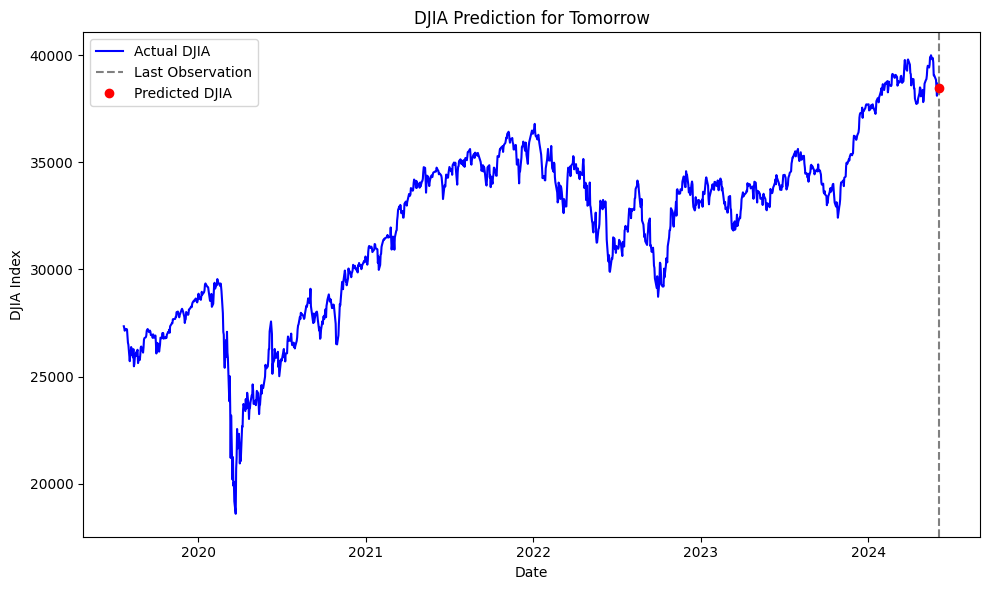

In [80]:
#ALL IN ONE FULL MODEL WORKING TO FIND ACCURACY AND EXTRA FEATURES
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import ta

def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def add_indicators(data):
    # Add Simple Moving Average (SMA)
    data['SMA'] = ta.trend.sma_indicator(data['Close'], window=14)
    # Add Exponential Moving Average (EMA)
    data['EMA'] = ta.trend.ema_indicator(data['Close'], window=14)
    # Add Relative Strength Index (RSI)
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
    # Add MACD
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Diff'] = macd.macd_diff()
    # Drop rows with NaN values
    data = data.dropna()
    return data

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

def split_train_test(X, y, train_ratio):
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

def build_model(seq_length, feature_count):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, feature_count)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def main():
    # Ticker for Dow Jones Industrial Average
    ticker_djia = '^DJI'
    start_date = '2019-06-05'  # Adjust this according to available data
    end_date = '2024-06-04'
    seq_length = 60
    train_ratio = 0.8

    # Fetching DJIA data
    data_djia = download_stock_data(ticker_djia, start_date, end_date)

    # Adding technical indicators
    data_djia = add_indicators(data_djia)

    # Selecting feature columns
    feature_columns = ['Close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
                       'Volume', 'Open', 'High', 'Low']
    data_djia_features = data_djia[feature_columns]

    # Preprocessing data
    scaled_data_djia, scaler_djia = preprocess_data(data_djia_features)

    # Creating sequences
    X_djia, y_djia = create_sequences(scaled_data_djia, seq_length)

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = split_train_test(X_djia, y_djia, train_ratio)

    # Building LSTM model
    model_djia = build_model(seq_length, X_train.shape[2])

    # Training the model
    model_djia.fit(X_train, y_train, epochs=10, batch_size=32)

    # Making predictions
    y_pred = model_djia.predict(X_test)

    # Inverse scaling
    y_test_scaled = y_test.reshape(-1, 1)
    y_test_inv = scaler_djia.inverse_transform(
        np.hstack((y_test_scaled, np.zeros((y_test_scaled.shape[0], scaled_data_djia.shape[1] - 1))))
    )[:, 0]
    y_pred_inv = scaler_djia.inverse_transform(
        np.hstack((y_pred, np.zeros((y_pred.shape[0], scaled_data_djia.shape[1] - 1))))
    )[:, 0]

    # Calculating Mean Absolute Percentage Error (MAPE)
    mape = calculate_mape(y_test_inv, y_pred_inv)
    print(f"Model Accuracy (MAPE): {100 - mape:.2f}%")

    # Making predictions for the next day
    last_sequence_djia = scaled_data_djia[-seq_length:].reshape(1, seq_length, X_djia.shape[2])
    prediction_djia = model_djia.predict(last_sequence_djia)
    prediction_djia = scaler_djia.inverse_transform(
        np.hstack((prediction_djia, np.zeros((prediction_djia.shape[0], scaled_data_djia.shape[1] - 1))))
    )[:, 0][0]

    print(f"Predicted DJIA for the next day: {prediction_djia}")

    # Displaying some information about the last observation
    last_row = data_djia.iloc[-1]
    print(f"Previous Close: {last_row['Close']}")
    print(f"SMA: {last_row['SMA']}")
    print(f"EMA: {last_row['EMA']}")
    print(f"RSI: {last_row['RSI']}")
    print(f"MACD: {last_row['MACD']}")
    print(f"Volume: {last_row['Volume']}")
    print(f"Open: {last_row['Open']}")
    print(f"High: {last_row['High']}")
    print(f"Low: {last_row['Low']}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data_djia.index, data_djia['Close'], label='Actual DJIA', color='blue')
    plt.axvline(x=data_djia.index[-1], linestyle='--', color='gray', label='Last Observation')
    plt.plot(data_djia.index[-1] + pd.Timedelta(days=1), prediction_djia, 'ro', label='Predicted DJIA')
    plt.title('DJIA Prediction for Tomorrow')
    plt.xlabel('Date')
    plt.ylabel('DJIA Index')
    plt.legend()
    plt.tight_layout()
    plt.show()

main()

